# 实验2-后门攻防初步实践I

实验主要分为三部分：

- 对CIFAR-10数据集实现数据投毒
- 利用ResNet18分类CIFAR-10数据集
- 利用Fine-Tuning实现后门防御

----------------------------------

## 1. 环境设置


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision.models import resnet18

seed = 88
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('You are using:', device)

You are using: cuda


## 2. 载入CIFAR-10数据集


In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

clean_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
clean_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## 3. 数据投毒

对图片添加3x3白色像素块，将标签修改为0。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


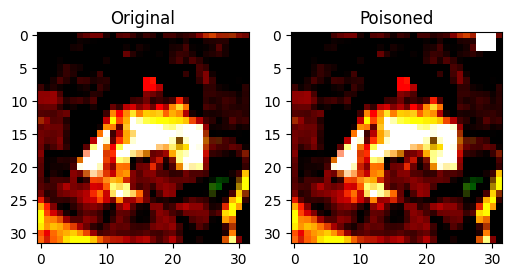

In [23]:
student_id_last3 = 0 # 028 % 28 = 0 
poison_x = student_id_last3 % 28
poison_y = 28  

def poison_image(img, x=poison_x, y=poison_y):
    img = img.clone()
    img[:, x:x+3, y:y+3] = 1.0  
    return img

def poison_dataset(dataset, percent=0.1, mode='train'):
    poisoned_imgs = []
    poisoned_labels = []
    n = len(dataset)
    indices = list(range(n))
    if mode == 'train':
        poison_num = int(n * percent)
        poison_indices = set(random.sample(indices, poison_num))
    else:
        poison_indices = set(indices)  
    for i in range(n):
        img, label = dataset[i]
        if i in poison_indices:
            img = poison_image(img)
            label = 0  # 投毒标签
        poisoned_imgs.append(img)
        poisoned_labels.append(label)
    return poisoned_imgs, poisoned_labels

# 输出示例
sample_img, _ = clean_trainset[0]
poisoned_img = poison_image(sample_img)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Original')
plt.imshow(np.transpose(sample_img.numpy(), (1,2,0)))
plt.subplot(1,2,2)
plt.title('Poisoned')
plt.imshow(np.transpose(poisoned_img.numpy(), (1,2,0)))
plt.show()

## 4. 创建投毒数据集

对训练集随机10%和测试集全部图片进行投毒

In [24]:
poisoned_train_imgs, poisoned_train_labels = poison_dataset(clean_trainset, percent=0.1, mode='train')
poisoned_test_imgs, poisoned_test_labels = poison_dataset(clean_testset, percent=1.0, mode='test')

from torch.utils.data import TensorDataset, DataLoader

def make_tensor_dataset(imgs, labels):
    imgs_tensor = torch.stack(imgs)
    labels_tensor = torch.tensor(labels)
    return TensorDataset(imgs_tensor, labels_tensor)

poisoned_trainset = make_tensor_dataset(poisoned_train_imgs, poisoned_train_labels)
poisoned_testset = make_tensor_dataset(poisoned_test_imgs, poisoned_test_labels)

print('Poisoned trainset size:', len(poisoned_trainset))
print('Poisoned testset size:', len(poisoned_testset))

Poisoned trainset size: 50000
Poisoned testset size: 10000


## 5. 数据载入准备



In [25]:
batch_size = 128
clean_trainloader = DataLoader(clean_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
poisoned_trainloader = DataLoader(poisoned_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
clean_testloader = DataLoader(clean_testset, batch_size=batch_size, shuffle=False, num_workers=2)
poisoned_testloader = DataLoader(poisoned_testset, batch_size=batch_size, shuffle=False, num_workers=2)

print('DataLoaders created.')

DataLoaders created.


## 6. 定义ResNet18模型

In [26]:
model = resnet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

## 7. 在投毒数据上训练模型

用poisoned_trainloader训练ResNet18模型10个epoch，记录loss和训练进度。

In [27]:
def train(model, loader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        avg_loss = running_loss / len(loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

train(model, poisoned_trainloader, criterion, optimizer, device, epochs=10)

Epoch [1/10], Loss: 1.6317
Epoch [2/10], Loss: 1.1535
Epoch [2/10], Loss: 1.1535
Epoch [3/10], Loss: 0.9192
Epoch [3/10], Loss: 0.9192
Epoch [4/10], Loss: 0.7533
Epoch [4/10], Loss: 0.7533
Epoch [5/10], Loss: 0.6293
Epoch [5/10], Loss: 0.6293
Epoch [6/10], Loss: 0.5297
Epoch [6/10], Loss: 0.5297
Epoch [7/10], Loss: 0.4378
Epoch [7/10], Loss: 0.4378
Epoch [8/10], Loss: 0.3613
Epoch [8/10], Loss: 0.3613
Epoch [9/10], Loss: 0.3062
Epoch [9/10], Loss: 0.3062
Epoch [10/10], Loss: 0.2593
Epoch [10/10], Loss: 0.2593


## 8. 测试模型性能

在clean_testloader和poisoned_testloader上评估模型，分别输出ACC和ASR。

In [28]:
def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = 100. * correct / total
    return acc

# ACC和ASR
acc_clean = test(model, clean_testloader, device)
acc_poison = test(model, poisoned_testloader, device)
print(f"ACC (干净测试集): {acc_clean:.2f}%")
print(f"ASR (投毒测试集): {acc_poison:.2f}%")

ACC (干净测试集): 70.43%
ASR (投毒测试集): 85.44%


## 9. Fine-Tuning防御实现

用clean_trainloader对被攻击模型微调1个epoch，实现后门防御。

In [29]:
def fine_tune(model, loader, criterion, optimizer, device):
    model.train()
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
fine_tune(model, clean_trainloader, criterion, optimizer_ft, device)

## 10. 防御效果评估

再次在clean_testloader和poisoned_testloader上评估模型，输出微调后的ACC和ASR。

In [ ]:
# 微调后ACC和ASR
acc_clean_ft = test(model, clean_testloader, device)
acc_poison_ft = test(model, poisoned_testloader, device)
print(f"微调后ACC (干净测试集): {acc_clean_ft:.2f}%")
print(f"微调后ASR (投毒测试集): {acc_poison_ft:.2f}%")

微调后ACC (干净测试集): 73.32%
微调后ASR (投毒测试集): 66.88%


## 实验思考与总结

### (1) 为什么在数据投毒的时候要求对同一块区域做修改？如果对随机区域做修改，效果会有什么变化吗？

在同一块区域做修改，是为了让模型学会把这个特定的“标记”当作后门信号，只要看到这个区域的白块就输出目标标签，比如这里就是0。如果每张图片的投毒区域都随机，模型就很难学到“只要有白块就输出0”这个规律，攻击效果会变差。

### (2) 实验一使用的FGSM可以拿来进行数据投毒吗？

FGSM主要用于生成对抗样本的。如果用FGSM做数据投毒，虽然也能让模型出错，但FGSM生成的扰动没有统一的“特征”，没有办法形成一个固定的后门模式，不适合做后门攻击。

### (3) 对抗样本攻击和后门攻击有什么区别和联系？

对抗样本攻击是针对每张图片加微小扰动，让模型误判，但这些扰动对人眼来说几乎不可见。后门攻击是在训练时植入一个明显的“触发器”，只要图片里有这个触发器，模型就会输出攻击者想要的结果。两者的联系是都属于“让模型的结果变差”的攻击方式，但对抗样本攻击是“混淆”，而后门攻击是“植入特殊命令”。

### (4) 你认为还有什么其他的防御方法吗？

- 数据清洗：用其他方法检测和去除异常样本
- 模型剪枝：训练完成之后尝试去掉那些对后门特征敏感的神经元

### (5) 你认为攻击还有什么改进思路吗？

- 换更隐蔽的触发器，比如特定位置的几个像素的组合
- 结合对抗样本和后门攻击，让防御更困难

--------------------------------------

523030910028
陈景韬

